### 1 About Dataset

Context
Animals (also called Metazoa) are multicellular, eukaryotic organisms in the biological kingdom Animalia. With few exceptions, animals consume organic material, breathe oxygen, are able to move, can reproduce sexually, and go through an ontogenetic stage in which their body consists of a hollow sphere of cells, the blastula, during embryonic development. Over 1.5 million living animal species have been described—of which around 1 million are insects—but it has been estimated there are over 7 million animal species in total. Animals range in length from 8.5 micrometers (0.00033 in) to 33.6 meters (110 ft). They have complex interactions with each other and their environments, forming intricate food webs. The scientific study of animals is known as zoology.

Most living animal species are in Bilateria, a clade whose members have a bilaterally symmetric body plan. The Bilateria include the protostomes—in which many groups of invertebrates are found, such as nematodes, arthropods, and mollusks—and the deuterostomes, containing both the echinoderms as well as the chordates, the latter containing the vertebrates. Life forms interpreted as early animals were present in the Ediacaran biota of the late Precambrian. Many modern animal phyla became clearly established in the fossil record as marine species during the Cambrian explosion, which began around 542 million years ago. 6,331 groups of genes common to all living animals have been identified; these may have arisen from a single common ancestor that lived 650 million years ago.

Source: Wikipedia

Content
In this Dataset, we have 5400 Animal Images in 90 different categories or classes.

<img src = 'https://i.imgur.com/Q9K6ixA.png'>

In [1]:
!pip install torchsummary --q
import numpy as np  
import pandas as pd  
from PIL import Image  
import matplotlib  
import matplotlib.pyplot as plt  
import matplotlib.patches as mpatches  
import warnings
import torch  
from torch import nn  
from torch import optim  
import torch.optim as optim  
import torch.nn.functional as F  
from torchvision import transforms, models  
from torch.autograd import Variable  
from torchvision.datasets import ImageFolder  
import torch.utils.data as data  
from torch.utils.data import DataLoader, TensorDataset  
import os
from torchsummary import summary  

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
!pip install opendatasets --q
import opendatasets as od
dataset_url = "https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  skjha69


Your Kaggle Key:

  ································


Dataset URL: https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals


100%|██████████| 656M/656M [00:05<00:00, 132MB/s]  


In [3]:
data_dir = '/kaggle/working/animal-image-dataset-90-different-animals/animals/animals'
class_names = os.listdir(data_dir)
class_names[:5] , len(class_names)

(['hamster', 'seahorse', 'panda', 'rat', 'squirrel'], 90)

## 2 . Data Augmentation and Image Folder
We can create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, we'll also apply some other transforms to the images. There are a few important changes we'll make while creating PyTorch datasets for training and validation:

1. **Use test set for validation**: Instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, we'll simply use the test set as our validation set. This just gives a little more data to train with. In general, once you have picked the best model architecture & hypeparameters using a fixed validation set, it is a good idea to retrain the same model on the entire dataset just to give it a small final boost in performance.
2. **Channel-wise data normalization**: We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others.

<img src="https://i.imgur.com/LYxXBVg.png" width="360">


3. **Randomized data augmentations**: We will apply randomly chosen transformations while loading images from the training dataset. Specifically, we will pad each image by 4 pixels, and then take a random crop of size 32 x 32 pixels, and then flip the image horizontally with a 50% probability. Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

In [6]:
# average  = torch.Tensor([0,0,0])
# standard_dev = torch.Tensor([0,0,0])
# images = ImageFolder(data_dir, transforms.ToTensor())
# for image in images:
#     average += image[0].mean([1,2])
#     standard_dev += image[0].std([1,2])
# average / len(images) , standard_dev / len(images)



> Mean , Standard Deviation -- [R,G,B]

(tensor([0.5087, 0.5006, 0.4405]), tensor([0.2128, 0.2084, 0.2120]))



In [4]:
stats = ((0.5087, 0.5006, 0.4405),(0.2128, 0.2084, 0.2120))

## 2.1 Prepare DataLoader

Now we've got a dataset ready to go.

The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or `DataLoader` for short.

The `DataLoader` does what you think it might do.

It helps load data into a model.

For training and for inference.

It turns a large `Dataset` into a Python iterable of smaller chunks.

These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

Why do this?

Because it's more computationally efficient.

In an ideal world you could do the forward pass and backward pass across all of your data at once.

But once you start using really large datasets, unless you've got infinite computing power, it's easier to break them up into batches.

It also gives your model more opportunities to improve.

With **mini-batches** (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

What's a good batch size?

[32 is a good place to start](https://twitter.com/ylecun/status/989610208497360896?s=20&t=N96J_jotN--PYuJk2WcjMw) for a fair amount of problems.

But since this is a value you can set (a **hyperparameter**) you can try all different kinds of values, though generally powers of 2 are used most often (e.g. 32, 64, 128, 256, 512).

Let's create `DataLoader`'s for our training and test sets.

In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.v2.Resize(size=(224, 224) , antialias = True),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(*stats,inplace = True),
        ]),
}

dataset = ImageFolder(
    root= data_dir,
    transform=data_transforms['train'],
)

### 2.1 Visualizing our data

In [6]:
class_names = dataset.classes
image , label = dataset[69]
image.shape , label

(torch.Size([3, 224, 224]), 1)

Text(0.5, 1.0, 'badger : 1')

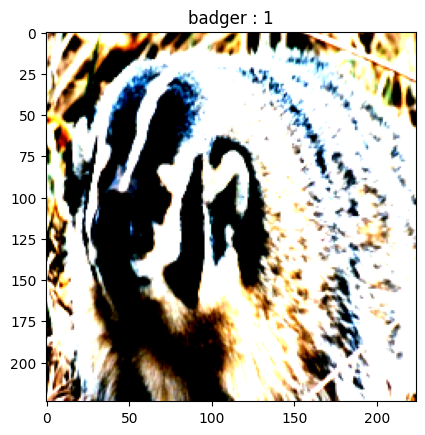

In [7]:
plt.imshow(image.permute(1, 2, 0))
plt.title(f'{class_names[label]} : {label}')

In [8]:
random_seed = 42
torch.manual_seed(random_seed);
from torch.utils.data import random_split
val_size = 500
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
len(train_data), len(val_data)

(4900, 500)

In [9]:
class_names = train_data.dataset.classes
class_names[:10]

['antelope',
 'badger',
 'bat',
 'bear',
 'bee',
 'beetle',
 'bison',
 'boar',
 'butterfly',
 'cat']

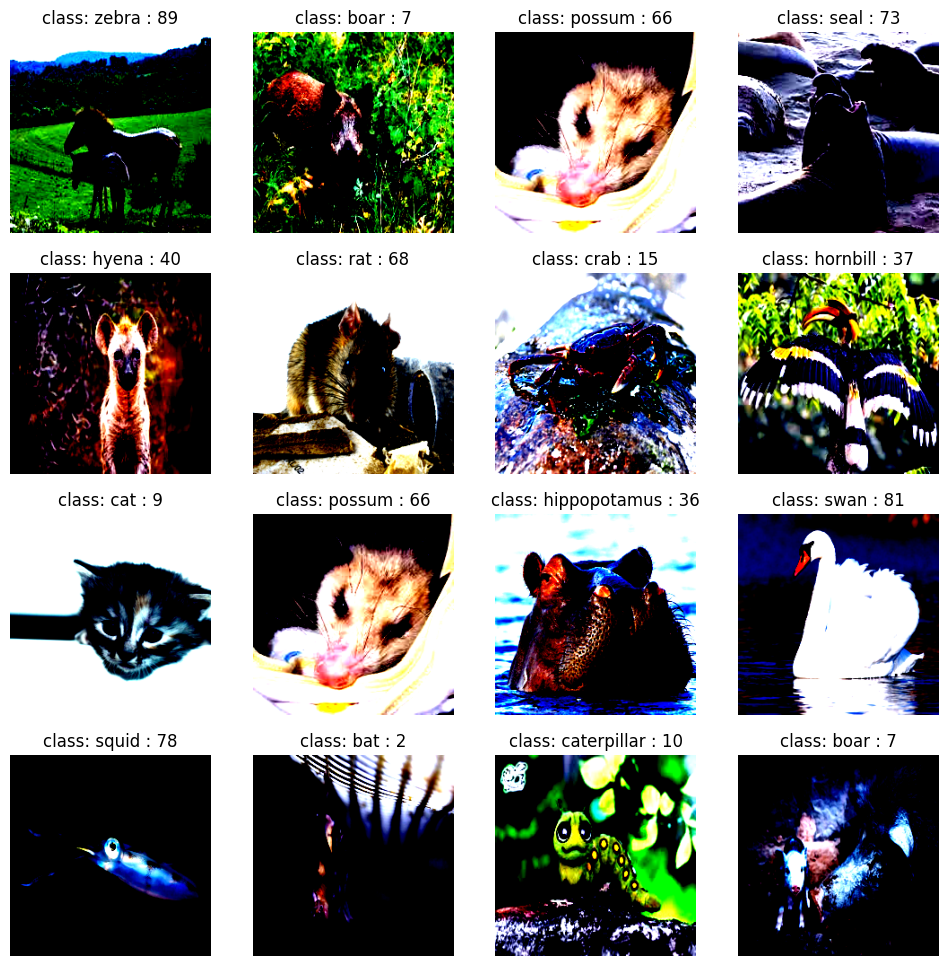

In [10]:
import random
import torch
import matplotlib.pyplot as plt

def plot_random_images(dataset:torch.utils.data.dataset.Dataset ,
                          class_names : list[str] = None,
                          n : int = 3,
                          seed : int = None)->None:
    if seed:
        random.seed(seed)

    fig = plt.figure(figsize=(12, 12))
    for i in range(1,n*n+1):
        random_idx = torch.randint(0 , len(dataset), size = [1]).item()
        image, target = dataset[random_idx]
        fig.add_subplot(n,n,i)
        plt.imshow(image.permute(1,2,0))
        plt.axis(False);
        if class_names:
            title = f"class: {class_names[target]} : {target}"
        else:
            title = None
        plt.title(title)
        
plot_random_images(dataset = val_data, n = 4 , class_names = class_names )

In [11]:
from torch.utils.data import DataLoader
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32 
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = True,
)

val_dataloader = DataLoader(
    dataset = val_data,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    shuffle = False
)

In [12]:
for images, labels in train_dataloader:
    print('images.shape:', images.shape)
    print(labels)
    break

images.shape: torch.Size([32, 3, 224, 224])
tensor([20, 29, 39, 32, 71, 14, 41, 26, 17, 78, 72, 66, 58, 84, 33, 12, 20, 65,
        78,  8, 27,  3, 42, 47, 56, 44, 77, 42, 56, 24, 21, 58])


## 3. Model : Building a Model | Transfer Learning | DarkNet53
Darknet-53 is a convolutional neural network architecture that is part of the Darknet framework, known primarily for its use in the YOLOv3 object detection system. It is designed to be efficient and robust, combining both residual connections and a high number of convolutional layers. Here’s a brief overview of the Darknet-53 architecture with an input image of size 3 x 224 x 224:

### Darknet-53 Architecture:

1. **Input Layer:**
   - Image size: 3 (channels) x 224 (height) x 224 (width).

2. **Convolutional Layers and Residual Blocks:**
   - **Conv1:** 32 filters of size 3x3, stride 1. Output: 32 x 224 x 224.
   
   - **Conv2:** 64 filters of size 3x3, stride 2. Output: 64 x 112 x 112.
     - **Residual Block:** Two 3x3 convolutions, each with 32 filters.
   
   - **Conv3:** 128 filters of size 3x3, stride 2. Output: 128 x 56 x 56.
     - **Residual Block:** Two 3x3 convolutions, each with 64 filters. (x2)
   
   - **Conv4:** 256 filters of size 3x3, stride 2. Output: 256 x 28 x 28.
     - **Residual Block:** Two 3x3 convolutions, each with 128 filters. (x8)
   
   - **Conv5:** 512 filters of size 3x3, stride 2. Output: 512 x 14 x 14.
     - **Residual Block:** Two 3x3 convolutions, each with 256 filters. (x8)
   
   - **Conv6:** 1024 filters of size 3x3, stride 2. Output: 1024 x 7 x 7.
     - **Residual Block:** Two 3x3 convolutions, each with 512 filters. (x4)

3. **Fully Connected Layers:**
   - **Global Average Pooling:** Reduces each feature map to a single value by averaging.
   - **FC:** 1000 units (for ImageNet classification).

4. **Output Layer:**
   - Softmax layer to produce probabilities for each class.

### Summary of Important Contents:
- **Residual Blocks:** These help in training deeper networks by allowing gradients to flow through the network directly.
- **Convolutional Layers:** Uses a series of convolutional layers with increasing filter sizes to extract features at different levels of abstraction.
- **Global Average Pooling:** Replaces fully connected layers to reduce the number of parameters and avoid overfitting.

### References:
- The original paper detailing YOLOv3, which introduces Darknet-53, can be found [here](https://arxiv.org/abs/1804.02767) .
- The implementation details and code for Darknet and Darknet-53 are available in the official [Darknet GitHub repository](https://github.com/pjreddie/darknet) .

Darknet-53 is designed to be more efficient and effective than previous versions, providing a good balance between accuracy and speed, making it suitable for real-time object detection tasks.

<img src = 'https://www.researchgate.net/publication/335865923/figure/fig1/AS:804106595758082@1568725360777/Structure-detail-of-YOLOv3It-uses-Darknet-53-as-the-backbone-network-and-uses-three.jpg'>

In [13]:
!pip install timm --q
import timm
from pprint import pprint
model_names = timm.list_models()

In [23]:
# pprint(model_names[:])

In [24]:
model = timm.create_model('darknet53',
                          pretrained=True,
                          num_classes = len(class_names)).to(device)

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

In [25]:
# Print the summary of the model
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
          Identity-2         [-1, 32, 224, 224]               0
         LeakyReLU-3         [-1, 32, 224, 224]               0
    BatchNormAct2d-4         [-1, 32, 224, 224]              64
       ConvNormAct-5         [-1, 32, 224, 224]               0
            Conv2d-6         [-1, 64, 112, 112]          18,432
          Identity-7         [-1, 64, 112, 112]               0
         LeakyReLU-8         [-1, 64, 112, 112]               0
    BatchNormAct2d-9         [-1, 64, 112, 112]             128
         Identity-10         [-1, 64, 112, 112]               0
    ConvNormActAa-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 32, 112, 112]           2,048
         Identity-13         [-1, 32, 112, 112]               0
        LeakyReLU-14         [-1, 32, 1

### 3.1 Setup loss, optimizer and evaluation metrics


> **Note:** Rather than importing and using our own accuracy function or evaluation metric(s), you could import various evaluation metrics from the [TorchMetrics package](https://torchmetrics.readthedocs.io/en/latest/).

In [27]:
# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001 , betas = (0.5, 0.999))

### 4 Functionizing training and test loops

So far we've been writing train and test loops over and over.

Let's write them again but this time we'll put them in functions so they can be called again and again.

And because we're using device-agnostic code now, we'll be sure to call `.to(device)` on our feature (`X`) and target (`y`) tensors.

For the training loop we'll create a function called `train_step()` which takes in a model, a `DataLoader` a loss function and an optimizer.

The testing loop will be similar but it'll be called `test_step()` and it'll take in a model, a `DataLoader`, a loss function and an evaluation function.


In [28]:
def train(model, train_loader, optimizer):
    # Set the model to training mode
    model.train()

    # Iterate through batches of data in the train_loader
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target tensors to the appropriate device (GPU if available, otherwise CPU)
        data, target = data.to(device), target.to(device)

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # Calculate the batch loss
        loss =  criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

In [29]:
def evaluate(model, test_loader):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for test loss and correct predictions
    test_loss = 0
    correct = 0

    # Turn off gradients during evaluation
    with torch.no_grad():
        # Iterate through batches of data in the test_loader
        for data, target in test_loader:
            # Move data and target tensors to the appropriate device (GPU if available, otherwise CPU)
            data, target = data.to(device), target.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # Compute the total test loss
            test_loss += criterion(output, target).item()

            # Get the index of the highest probability prediction
            pred = output.max(1, keepdim=True)[1]

            # Count the number of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate the average test loss
    test_loss /= len(test_loader.dataset)

    # Calculate the test accuracy
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


### 5 Creating a training loop and training a model on batches of data

Beautiful!

Looks like we've got all of the pieces of the puzzle ready to go, a timer, a loss function, an optimizer, a model and most importantly, some data.

Let's now create a training loop and a testing loop to train and evaluate our model.

We'll be using the same steps as the previous notebook(s), though since our data is now in batch form, we'll add another loop to loop through our data batches.

Our data batches are contained within our `DataLoader`s, `train_dataloader` and `test_dataloader` for the training and test data splits respectively.

A batch is `BATCH_SIZE` samples of `X` (features) and `y` (labels), since we're using `BATCH_SIZE=32`, our batches have 32 samples of images and targets.

And since we're computing on batches of data, our loss and evaluation metrics will be calculated **per batch** rather than across the whole dataset.

This means we'll have to divide our loss and accuracy values by the number of batches in each dataset's respective dataloader.

Let's step through it:
1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all (for fun).

A fair few steps but...

...if in doubt, code it out.

In [30]:
import time  # Importing time module for time tracking
import copy  # Importing copy module for deep copying model weights

def train_model(model, train_loader, val_loader, optimizer, num_epochs=30):
    # Lists to store training and validation accuracies and losses for each epoch
    acc_t = []  # Training accuracy
    acc_v = []  # Validation accuracy
    loss_t = []  # Training loss
    loss_v = []  # Validation loss

    best_acc = 0.0  # Best validation accuracy initialized to 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # Deep copy of model weights as the best model

    # Loop through each epoch
    for epoch in range(1, num_epochs + 1):
        since = time.time()  # Record the start time of the epoch

        # Train the model for one epoch
        train(model, train_loader, optimizer)

        # Evaluate the model on the training and validation sets to get loss and accuracy
        train_loss, train_acc = evaluate(model, train_loader)
        val_loss, val_acc = evaluate(model, val_loader)

        # Update the best validation accuracy and best model weights if the current validation accuracy is higher
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Append current epoch's accuracy and loss values to the lists
        acc_t.append(train_acc)
        acc_v.append(val_acc)
        loss_t.append(train_loss)
        loss_v.append(val_loss)

        time_elapsed = time.time() - since  # Calculate time elapsed for the epoch

        # Print epoch statistics
        print('-------------- EPOCH {} ----------------'.format(epoch))
        print('Train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))
        print('Val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print()

    # Plot accuracy graph
    plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
    red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

    # Plot loss graph
    plt.plot(range(len(loss_t)), loss_t, 'b', range(len(loss_v)), loss_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Loss')
    red_patch = mpatches.Patch(color='red', label='Validation Loss')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Return the model with the best weights
    return model

-------------- EPOCH 1 ----------------
Train Loss: 0.0028, Accuracy: 97.96%
Val Loss: 0.0326, Accuracy: 76.40%
Time: 1m 44s

-------------- EPOCH 2 ----------------
Train Loss: 0.0571, Accuracy: 81.78%
Val Loss: 0.1167, Accuracy: 62.20%
Time: 1m 45s

-------------- EPOCH 3 ----------------
Train Loss: 0.0005, Accuracy: 99.53%
Val Loss: 0.0287, Accuracy: 80.80%
Time: 1m 45s

-------------- EPOCH 4 ----------------
Train Loss: 0.1239, Accuracy: 57.51%
Val Loss: 0.1827, Accuracy: 45.40%
Time: 1m 45s

-------------- EPOCH 5 ----------------
Train Loss: 0.0170, Accuracy: 88.22%
Val Loss: 0.0664, Accuracy: 64.80%
Time: 1m 46s

-------------- EPOCH 6 ----------------
Train Loss: 0.0054, Accuracy: 97.02%
Val Loss: 0.0392, Accuracy: 75.60%
Time: 1m 44s

-------------- EPOCH 7 ----------------
Train Loss: 0.0153, Accuracy: 87.92%
Val Loss: 0.0631, Accuracy: 65.00%
Time: 1m 45s

-------------- EPOCH 10 ----------------
Train Loss: 0.0042, Accuracy: 96.33%
Val Loss: 0.0444, Accuracy: 72.40%
Time:

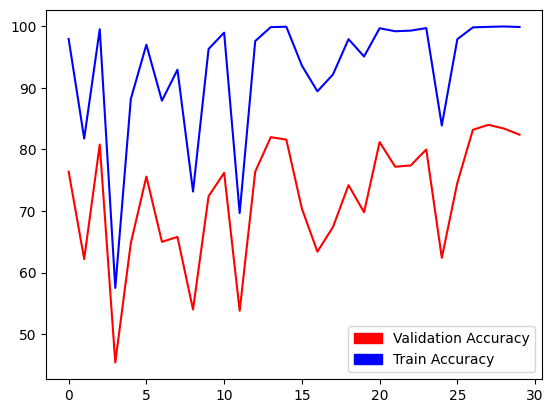

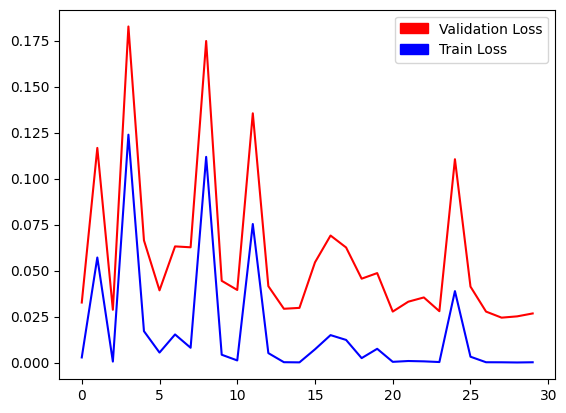

In [39]:
# Defining the number of epochs for training
EPOCH = 60

# Calling the train_model function to train the model
# The function takes the current model, training data loader (train_loader),
# validation data loader (val_loader), optimizer, and number of epochs as inputs
model = train_model(model, train_dataloader, val_dataloader, optimizer, EPOCH)
# The trained model with the best validation accuracy is returned and assigned to the variable 'model'

## 6. Evaluate Model

In [40]:
# Set the model to evaluation mode
model.eval()

# Evaluate the model on the training data to get the training accuracy
# The evaluate function returns both loss and accuracy, but we're only interested in accuracy here,
# hence using '_' to ignore the loss value
_, train_acc = evaluate(model, train_dataloader)

# Evaluate the model on the validation data to get the validation accuracy
_, val_acc = evaluate(model, val_dataloader)

# Print the saved model's training accuracy
print('Train Accuracy: {:.4f}'.format(train_acc))

# Print the saved model's validation accuracy
print('Validation Accuracy: {:.4f}'.format(val_acc))

Train Accuracy: 99.8980
Validation Accuracy: 84.0000


## 7. Making a confusion matrix for further prediction evaluation

There are many [different evaluation metrics](https://www.learnpytorch.io/02_pytorch_classification/#9-more-classification-evaluation-metrics) we can use for classification problems.

One of the most visual is a [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/).

A confusion matrix shows you where your classification model got confused between predicitons and true labels.

To make a confusion matrix, we'll go through three steps:
1. Make predictions with our trained model, `model_2` (a confusion matrix compares predictions to true labels).
2. Make a confusion matrix using [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html?highlight=confusion#confusionmatrix).
3. Plot the confusion matrix using [`mlxtend.plotting.plot_confusion_matrix()`](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/).

Let's start by making predictions with our trained model.

In [57]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

import random
# random.seed(69)
test_samples = []
test_labels = []
for sample, label in random.sample(list(val_data), k=16):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs= make_predictions(model=model,
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)
pred_classes

test_labels, pred_classes

([5, 40, 85, 54, 57, 25, 86, 23, 22, 79, 45, 30, 77, 82, 27, 77],
 tensor([ 5, 40, 85, 54, 57, 25, 14, 23, 30, 79, 45, 30, 61, 82, 27, 71]))

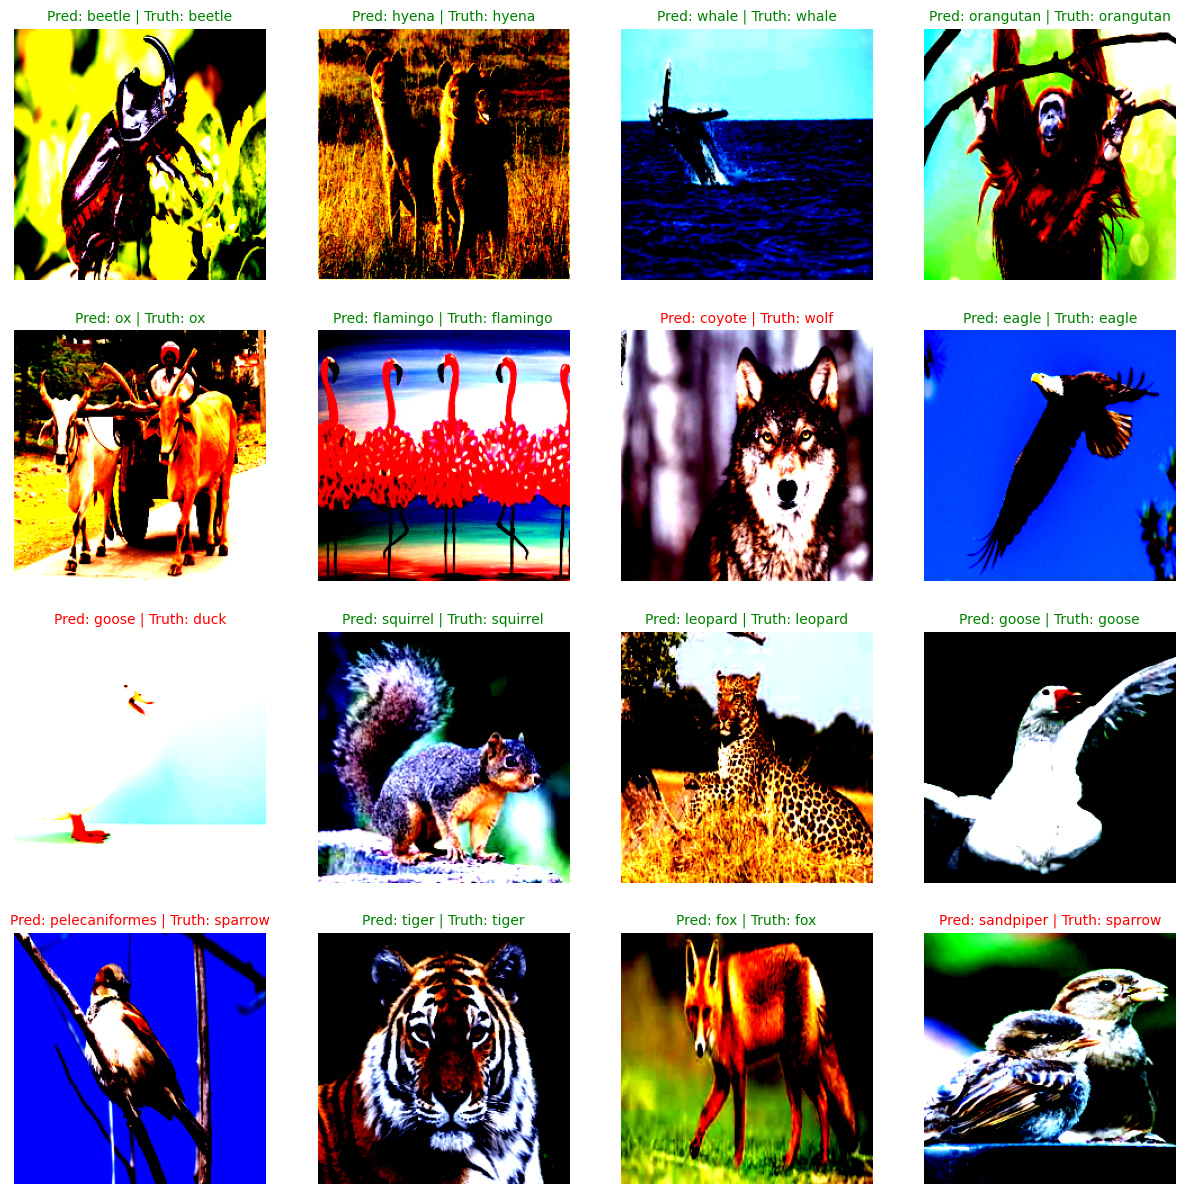

In [58]:
# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 4
ncols = 4
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1,2,0), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [54]:
def get_preds(model , dataloader , device = device):
    from tqdm.auto import tqdm
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions"):

            X, y = X.to(device), y.to(device)

            y_logit = model(X)

            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

            y_preds.append(y_pred.cpu())

    y_pred_tensor = torch.cat(y_preds)
    return y_pred_tensor
val_preds = get_preds(model , val_dataloader)
val_preds[:10]

Making predictions:   0%|          | 0/16 [00:00<?, ?it/s]

tensor([ 8, 68,  8, 87, 18, 19, 27, 53, 15, 67])

In [44]:
val_targets = [label for image , label  in val_data]

## 8. Classification Report

In [59]:
from sklearn.metrics import classification_report
report = classification_report(val_targets, val_preds)
print(report)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         4
           1       0.75      0.75      0.75         4
           2       1.00      0.80      0.89         5
           3       0.75      0.75      0.75         4
           4       1.00      0.50      0.67         4
           5       1.00      1.00      1.00         3
           6       0.89      0.80      0.84        10
           7       0.75      0.86      0.80         7
           8       0.80      0.57      0.67         7
           9       1.00      0.86      0.92         7
          10       1.00      0.70      0.82        10
          11       1.00      0.71      0.83         7
          12       0.71      1.00      0.83         5
          13       1.00      0.83      0.91         6
          14       0.43      0.43      0.43         7
          15       0.75      0.75      0.75         8
          16       1.00      0.89      0.94         9
          17       0.71    

## 9. Save and load best performing model

Let's finish this section off by saving and loading in our best performing model.

Recall from [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/#5-saving-and-loading-a-pytorch-model) we can save and load a PyTorch model using a combination of:
* `torch.save` - a function to save a whole PyTorch model or a model's `state_dict()`.
* `torch.load` - a function to load in a saved PyTorch object.
* `torch.nn.Module.load_state_dict()` - a function to load a saved `state_dict()` into an existing model instance.

You can see more of these three in the [PyTorch saving and loading models documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

For now, let's save our `model_2`'s `state_dict()` then load it back in and evaluate it to make sure the save and load went correctly.

In [60]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("pytorch saved model")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "AnimalImageClassificationDarkNet53.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: pytorch saved model/AnimalImageClassificationDarkNet53.pth


In [61]:
loaded_model = model

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = loaded_model.to(device)

In [65]:
# Set the model to evaluation mode
loaded_model.eval()

# Evaluate the model on the training data to get the training accuracy
# The evaluate function returns both loss and accuracy, but we're only interested in accuracy here,
# hence using '_' to ignore the loss value
_, train_acc = evaluate(loaded_model, train_dataloader)

# Evaluate the model on the validation data to get the validation accuracy
_, val_acc = evaluate(loaded_model, val_dataloader)

# Print the saved model's training accuracy
print('Train Accuracy: {:.4f}%'.format(train_acc))

# Print the saved model's validation accuracy
print('Validation Accuracy: {:.4f}%'.format(val_acc))

Train Accuracy: 99.8776%
Validation Accuracy: 83.2000%
